In [5]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_tracking/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)

In [2]:
sessionA = 'classinsight-cmu_05748A_ghc_4101_201902051630'
sessionB = 'classinsight-cmu_05748A_ghc_4101_201902141630'
course = '05748A'

In [3]:
sessionA_frame_dir = f'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb/{course}/{sessionA}-front'
sessionB_frame_dir = f'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb/{course}/{sessionB}-front'

In [35]:
sessionA_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/track/05748A/classinsight-cmu_05748A_ghc_4101_201902051630-front'

# Cache and get tracking information for sessions

### Get frame file data for all sessions

In [7]:
track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb/'
frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
        
frame_file_data.keys()

dict_keys(['05410A', '21127J', '05748A', '05418A', '05681A', '17214B', '17214C', '05410B'])

## Collect only tracking data for both sessions

In [11]:
# writing a generic loop to get only-tracking info from all courses in frame file data, but putting a filter ahead
track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

for course_idx, course in enumerate(frame_file_data):
    for session_idx, session_id in enumerate(frame_file_data[course]):
        if session_id.split("-front")[0] in [sessionA, sessionB]:
            session_tracking_cache_file = f"{track_analysis_session_data}/{session_id}.pb"
            try:
                if not os.path.exists(session_tracking_cache_file):
                    session_dir = frame_file_data[course][session_id]['dir_location']
                    frame_ids = frame_file_data[course][session_id]['frame_ids']
                    session_tracking_ids = {}
                    for frame_id in frame_ids:
                        frame_data = pickle.load(open(f'{session_dir}/{frame_id}.pb','rb'))
                        frame_tracking_ids = [xr['track_id'] for xr in frame_data[1]]
                        # print(frame_id, frame_tracking_ids)
                        session_tracking_ids[frame_id] = {int(xr):1 for xr in frame_tracking_ids}
                    df_session_ids = pd.DataFrame.from_dict(session_tracking_ids)
                    pickle.dump(df_session_ids, open(session_tracking_cache_file,'wb'))
                    print(f"Got tracking info for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
                else:
                    ...
                    print(f"FILE EXISTS: tracking info for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
            except:
                print(f"ERROR: Unable to get session tracking for: {course_idx}-{course}, session:{session_idx}-{session_id}")
                unfinished_sessions.append((course, session_id))
                print(traceback.format_exc())
        

FILE EXISTS: tracking info for session: 2-05748A, session:0-classinsight-cmu_05748A_ghc_4101_201902051630-front
FILE EXISTS: tracking info for session: 2-05748A, session:1-classinsight-cmu_05748A_ghc_4101_201902141630-front


In [13]:
df_trackingA = pickle.load(open(f'{track_analysis_session_data}/{sessionA}-front.pb','rb')).transpose()
df_trackingA.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [14]:
df_trackingB = pickle.load(open(f'{track_analysis_session_data}/{sessionB}-front.pb','rb')).transpose()
df_trackingB.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [15]:
df_trackingA.shape, df_trackingB.shape

((11922, 1417), (23913, 1391))

## Filter tracking ids which do not stay persistent

In [16]:
MIN_ID_FRAMES = 900
MAX_ID_DISTANCE = 900
MAX_BBOX_OVERLAP = 0.4


In [18]:
# Filter for sessionA
col_start_stop_idxs = []
for col in df_trackingA.columns:
    one_idxs = df_trackingA.index[np.where(df_trackingA[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stopA = df_id_start_stop[df_id_start_stop.total_idxs>MIN_ID_FRAMES].reset_index(drop=True)

# Filter for sessionB
col_start_stop_idxs = []
for col in df_trackingB.columns:
    one_idxs = df_trackingB.index[np.where(df_trackingB[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stopB = df_id_start_stop[df_id_start_stop.total_idxs>MIN_ID_FRAMES].reset_index(drop=True)


df_id_start_stopA.shape, df_id_start_stopB.shape

((50, 4), (54, 4))

## Merge IDs across time based on start-stop and bounding box overlap

### Merge for sessionA

In [32]:
sessionA_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_gaze_emb/05748A/classinsight-cmu_05748A_ghc_4101_201902051630-front'

In [37]:
# SessionA
potential_id_maps = {}
num_possible_maps = 0 
for row_idx, row in df_id_start_stopA.iterrows():
    row_maxidx = row['max_idx']
    
    # get polygon for given id
    id_max_frame = row_maxidx
    id_frame_data = pickle.load(open(f"{sessionA_frame_dir}/{id_max_frame}.pb","rb"))[1]
    id_frame_data = [xr for xr in id_frame_data if (xr['track_id']==row['id'])][0]
    id_bb = id_frame_data['bbox'][:4].astype(int)
    X_TL1, Y_TL1, X_BR1, Y_BR1 = id_bb
    p1, p2, p3, p4  = map(Point, [[X_TL1,Y_TL1], [X_TL1,Y_BR1], [X_BR1,Y_BR1],[X_BR1, Y_TL1]]) 
    id_polygon = Polygon(p1, p2, p3, p4)
    
    potential_id_matches = df_id_start_stopA[(df_id_start_stopA.min_idx<=row_maxidx+MAX_ID_DISTANCE) & (df_id_start_stopA.min_idx>row_maxidx-MAX_ID_DISTANCE)].id.values
    successful_matches = []
    if len(potential_id_matches)>0:
        num_possible_maps+=1
        print('\n',row['id'], potential_id_matches, row['min_idx'],row['max_idx'],row['total_idxs'])
        for matched_id in potential_id_matches:
            matched_id_min_frame = df_id_start_stopA[df_id_start_stopA.id==matched_id].min_idx.values[0]
            matched_id_frame_data = pickle.load(open(f"{sessionA_frame_dir}/{matched_id_min_frame}.pb","rb"))[1]
            matched_id_frame_data = [xr for xr in matched_id_frame_data if (xr['track_id']==matched_id)][0]
            matched_id_bb = matched_id_frame_data['bbox'][:4].astype(int)
            X_TL2, Y_TL2, X_BR2, Y_BR2 = matched_id_bb
            
            p1, p2, p3, p4  = map(Point, [[X_TL2,Y_TL2], [X_TL2,Y_BR2], [X_BR2,Y_BR2],[X_BR2, Y_TL2]]) 
            matched_id_polygon = Polygon(p1, p2, p3, p4)
            
            #find intersection of two polygons
            # check if intersection exists
            if id_polygon.encloses_point(matched_id_polygon.centroid) & matched_id_polygon.encloses_point(id_polygon.centroid):
                X_TL_in, X_BR_in = sorted([X_TL1,X_TL2, X_BR1, X_BR2])[1:3]
                Y_TL_in, Y_BR_in = sorted([Y_TL1,Y_TL2, Y_BR1, Y_BR2])[1:3]
                p1, p2, p3, p4  = map(Point, [[X_TL_in,Y_TL_in], [X_TL_in,Y_BR_in], [X_BR_in,Y_BR_in],[X_BR_in, Y_TL_in]]) 
                intersection = Polygon(p1, p2, p3, p4)            

                #find polygon overlap
                area_intersection = np.abs(intersection.area)
                area_union = np.abs(id_polygon.area) + np.abs(matched_id_polygon.area) - area_intersection
                overlap_fraction  = (area_intersection/area_union).evalf()
            else:
                overlap_fraction=0.            
            if overlap_fraction > MAX_BBOX_OVERLAP:
                successful_matches.append((matched_id, overlap_fraction))
            
            print('\tMatching Id: ', matched_id,':', 'frame:',matched_id_min_frame,'overlap_fraction:', overlap_fraction)
    if len(successful_matches) > 0:
        successful_matched_id = sorted(successful_matches, key=lambda x: x[1])[-1][0]
        print('\t Successful match id:',successful_matched_id)
        if row['id'] in potential_id_maps.keys():
            potential_id_maps[successful_matched_id] = potential_id_maps[row['id']]
        else:
            potential_id_maps[successful_matched_id] = row['id']
        
        
    
        #     print('\tMatching Ids: ', row['id'], matched_id,':', id_max_frame, matched_id_min_frame)
        #     print('\tPoly id: ', id_polygon, id_polygon.area, id_polygon.centroid.evalf())
        #     print('\tPoly matched id: ', matched_id_polygon, matched_id_polygon.area, matched_id_polygon.centroid.evalf())
        #     print('\tIntersection:', intersection, intersection.area, intersection.centroid.evalf())
        #     break
        # break
    # potential_id_maps[row['id']] = potential_id_matches
potential_id_mapsA = deepcopy(potential_id_maps)
num_possible_mapsA = int(num_possible_maps)
print(num_possible_mapsA)


 4 [79 82] 0 3462 3462
	Matching Id:  79 : frame: 3318 overlap_fraction: 0.0
	Matching Id:  82 : frame: 3474 overlap_fraction: 0.0

 10 [23 38 50] 0 1488 1488
	Matching Id:  23 : frame: 858 overlap_fraction: 0.0
	Matching Id:  38 : frame: 1536 overlap_fraction: 0.736336620870839
	Matching Id:  50 : frame: 1908 overlap_fraction: 0.0
	 Successful match id: 38

 14 [690 692 697] 210 40254 40044
	Matching Id:  690 : frame: 39948 overlap_fraction: 0.359368072246984
	Matching Id:  692 : frame: 40272 overlap_fraction: 0.0
	Matching Id:  697 : frame: 40326 overlap_fraction: 0.395175498034964

 38 [163 164] 1536 6216 4680
	Matching Id:  163 : frame: 6414 overlap_fraction: 0.966901974925108
	Matching Id:  164 : frame: 6468 overlap_fraction: 0.0
	 Successful match id: 163

 50 [1287 1310] 1908 68688 66780
	Matching Id:  1287 : frame: 68124 overlap_fraction: 0.0
	Matching Id:  1310 : frame: 68568 overlap_fraction: 0.640478561070107
	 Successful match id: 1310

 120 [627 649] 4404 35766 31362
	Mat

### Do it for sessionB

In [40]:
# SessionA
potential_id_maps = {}
num_possible_maps = 0 
for row_idx, row in df_id_start_stopB.iterrows():
    row_maxidx = row['max_idx']
    
    # get polygon for given id
    id_max_frame = row_maxidx
    id_frame_data = pickle.load(open(f"{sessionB_frame_dir}/{id_max_frame}.pb","rb"))[1]
    id_frame_data = [xr for xr in id_frame_data if (xr['track_id']==row['id'])][0]
    id_bb = id_frame_data['bbox'][:4].astype(int)
    X_TL1, Y_TL1, X_BR1, Y_BR1 = id_bb
    p1, p2, p3, p4  = map(Point, [[X_TL1,Y_TL1], [X_TL1,Y_BR1], [X_BR1,Y_BR1],[X_BR1, Y_TL1]]) 
    id_polygon = Polygon(p1, p2, p3, p4)
    
    potential_id_matches = df_id_start_stopB[(df_id_start_stopB.min_idx<=row_maxidx+MAX_ID_DISTANCE) & (df_id_start_stopB.min_idx>row_maxidx-MAX_ID_DISTANCE)].id.values
    successful_matches = []
    if len(potential_id_matches)>0:
        num_possible_maps+=1
        print('\n',row['id'], potential_id_matches, row['min_idx'],row['max_idx'],row['total_idxs'])
        for matched_id in potential_id_matches:
            matched_id_min_frame = df_id_start_stopB[df_id_start_stopB.id==matched_id].min_idx.values[0]
            matched_id_frame_data = pickle.load(open(f"{sessionB_frame_dir}/{matched_id_min_frame}.pb","rb"))[1]
            matched_id_frame_data = [xr for xr in matched_id_frame_data if (xr['track_id']==matched_id)][0]
            matched_id_bb = matched_id_frame_data['bbox'][:4].astype(int)
            X_TL2, Y_TL2, X_BR2, Y_BR2 = matched_id_bb
            
            p1, p2, p3, p4  = map(Point, [[X_TL2,Y_TL2], [X_TL2,Y_BR2], [X_BR2,Y_BR2],[X_BR2, Y_TL2]]) 
            matched_id_polygon = Polygon(p1, p2, p3, p4)
            
            #find intersection of two polygons
            # check if intersection exists
            if id_polygon.encloses_point(matched_id_polygon.centroid) & matched_id_polygon.encloses_point(id_polygon.centroid):
                X_TL_in, X_BR_in = sorted([X_TL1,X_TL2, X_BR1, X_BR2])[1:3]
                Y_TL_in, Y_BR_in = sorted([Y_TL1,Y_TL2, Y_BR1, Y_BR2])[1:3]
                p1, p2, p3, p4  = map(Point, [[X_TL_in,Y_TL_in], [X_TL_in,Y_BR_in], [X_BR_in,Y_BR_in],[X_BR_in, Y_TL_in]]) 
                intersection = Polygon(p1, p2, p3, p4)            

                #find polygon overlap
                area_intersection = np.abs(intersection.area)
                area_union = np.abs(id_polygon.area) + np.abs(matched_id_polygon.area) - area_intersection
                overlap_fraction  = (area_intersection/area_union).evalf()
            else:
                overlap_fraction=0.            
            if overlap_fraction > MAX_BBOX_OVERLAP:
                successful_matches.append((matched_id, overlap_fraction))
            
            print('\tMatching Id: ', matched_id,':', 'frame:',matched_id_min_frame,'overlap_fraction:', overlap_fraction)
    if len(successful_matches) > 0:
        successful_matched_id = sorted(successful_matches, key=lambda x: x[1])[-1][0]
        print('\t Successful match id:',successful_matched_id)
        if row['id'] in potential_id_maps.keys():
            potential_id_maps[successful_matched_id] = potential_id_maps[row['id']]
        else:
            potential_id_maps[successful_matched_id] = row['id']
        
        
    
        #     print('\tMatching Ids: ', row['id'], matched_id,':', id_max_frame, matched_id_min_frame)
        #     print('\tPoly id: ', id_polygon, id_polygon.area, id_polygon.centroid.evalf())
        #     print('\tPoly matched id: ', matched_id_polygon, matched_id_polygon.area, matched_id_polygon.centroid.evalf())
        #     print('\tIntersection:', intersection, intersection.area, intersection.centroid.evalf())
        #     break
        # break
    # potential_id_maps[row['id']] = potential_id_matches
potential_id_mapsB = deepcopy(potential_id_maps)
num_possible_mapsB = int(num_possible_maps)
print(num_possible_mapsB)


 3 [1165 1178] 0 60963 60963
	Matching Id:  1165 : frame: 60147 overlap_fraction: 0.736612390706827
	Matching Id:  1178 : frame: 61374 overlap_fraction: 0.0
	 Successful match id: 1165

 4 [302] 0 13917 13917
	Matching Id:  302 : frame: 14067 overlap_fraction: 0.832130461131618
	 Successful match id: 302

 7 [25 30 32 34 35 49] 0 1212 1212
	Matching Id:  25 : frame: 849 overlap_fraction: 0.0
	Matching Id:  30 : frame: 1128 overlap_fraction: 0.587407241109405
	Matching Id:  32 : frame: 1152 overlap_fraction: 0.0
	Matching Id:  34 : frame: 1221 overlap_fraction: 0.0
	Matching Id:  35 : frame: 1269 overlap_fraction: 0.0
	Matching Id:  49 : frame: 1866 overlap_fraction: 0.0
	 Successful match id: 30

 8 [937] 0 52224 52224
	Matching Id:  937 : frame: 51909 overlap_fraction: 0.0

 9 [25 30 32 34 35 49] 0 1023 1023
	Matching Id:  25 : frame: 849 overlap_fraction: 0.0
	Matching Id:  30 : frame: 1128 overlap_fraction: 0.0
	Matching Id:  32 : frame: 1152 overlap_fraction: 0.802610261026103
	Ma

In [41]:
potential_id_mapsB

{1165: 3,
 302: 4,
 30: 7,
 32: 9,
 1185: 13,
 178: 7,
 68: 9,
 206: 121,
 323: 7,
 243: 121,
 1189: 277,
 745: 7,
 807: 7,
 1196: 984,
 1157: 1036,
 1178: 1036,
 1233: 984}

In [42]:
potential_id_mapsA

{38: 10,
 163: 10,
 1310: 50,
 627: 120,
 185: 10,
 460: 10,
 805: 120,
 692: 649,
 713: 649,
 758: 649,
 821: 649,
 1006: 649,
 1162: 1092,
 1220: 1092,
 1287: 1092}

## Plot final tracking id maps for both sessions

New tracking id for session A, (11922, 1400)


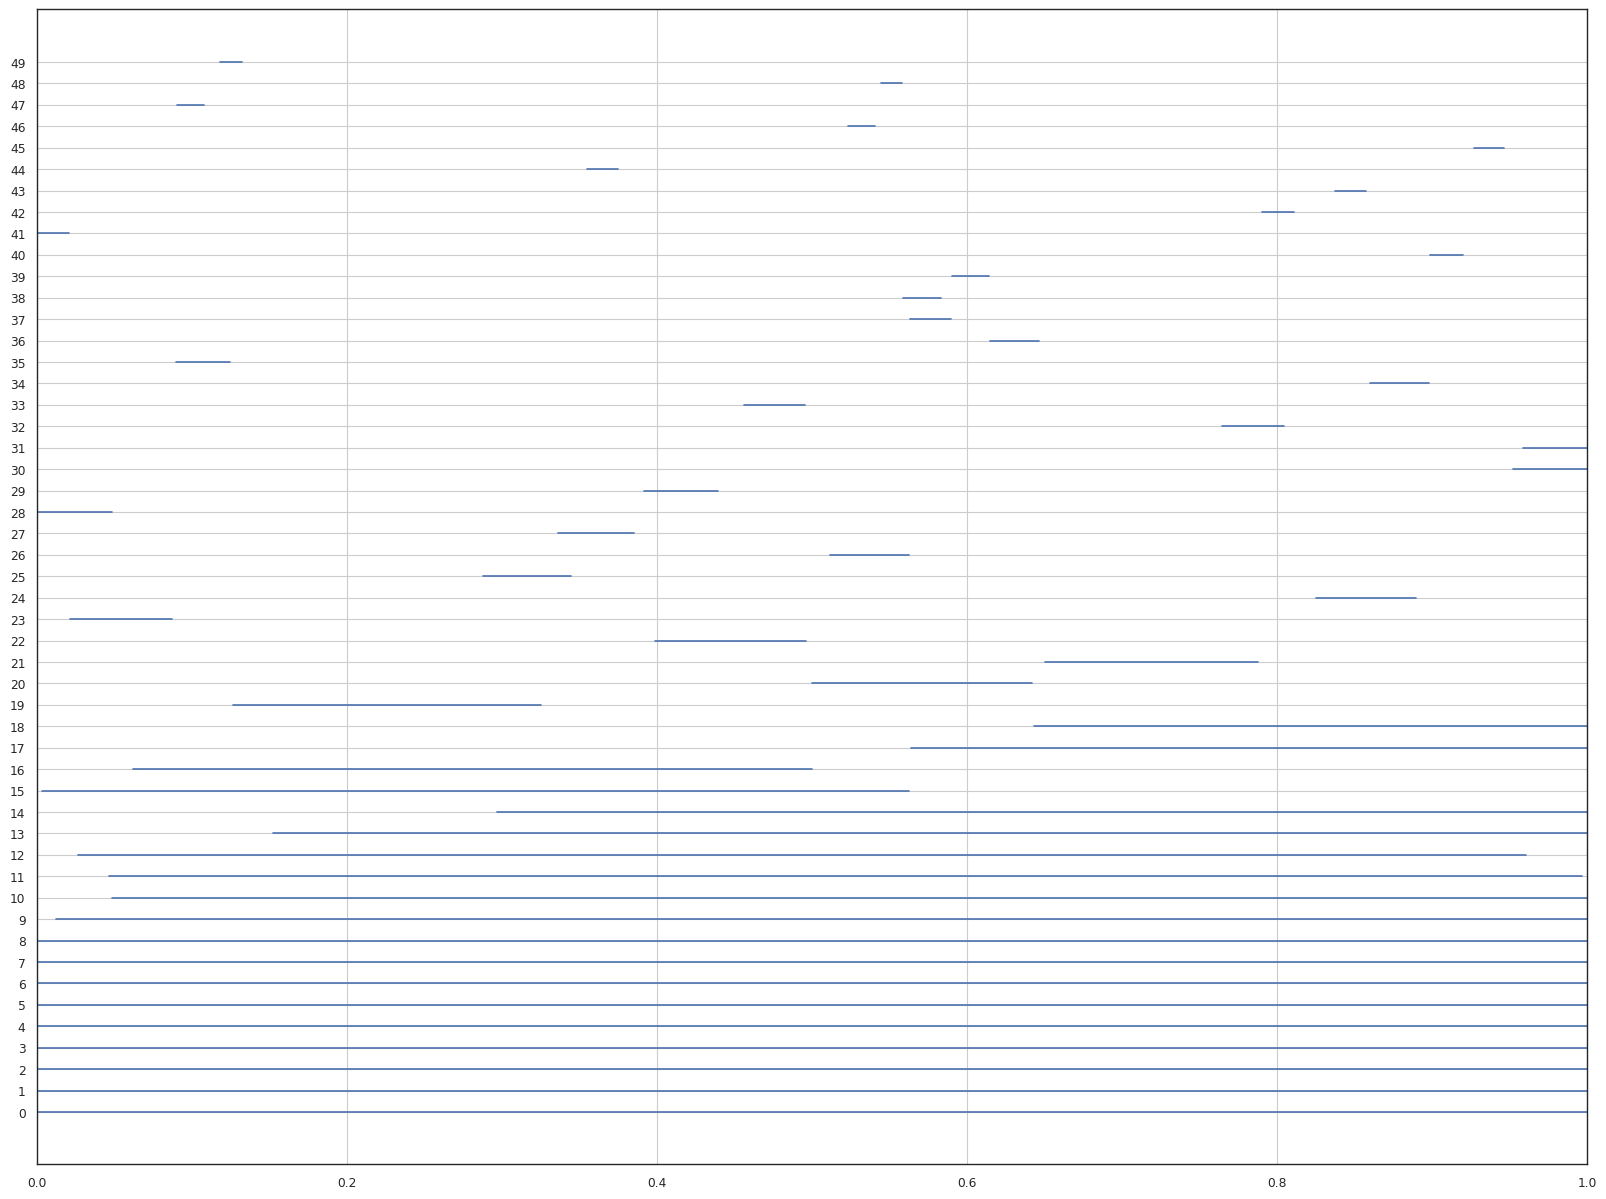

In [44]:
df_tracking_new = df_trackingA.copy(deep=True)
total_idxs = df_id_start_stopA.max_idx.max()
for matched_id in potential_id_maps:
    to_match_id = potential_id_maps[matched_id]
    df_tracking_new[to_match_id] =  df_tracking_new[to_match_id].where(~df_tracking_new[to_match_id].isnull(), df_tracking_new[to_match_id])
    df_tracking_new = df_tracking_new.drop(matched_id, axis=1)
print("New tracking id for session A,",df_tracking_new.shape)
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop = df_id_start_stop[df_id_start_stop.total_idxs>MIN_ID_FRAMES].reset_index(drop=True)
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.sort_values(by='total_idxs',ascending=False).reset_index(drop=True).iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid()   

New tracking id for session A, (23913, 1374)


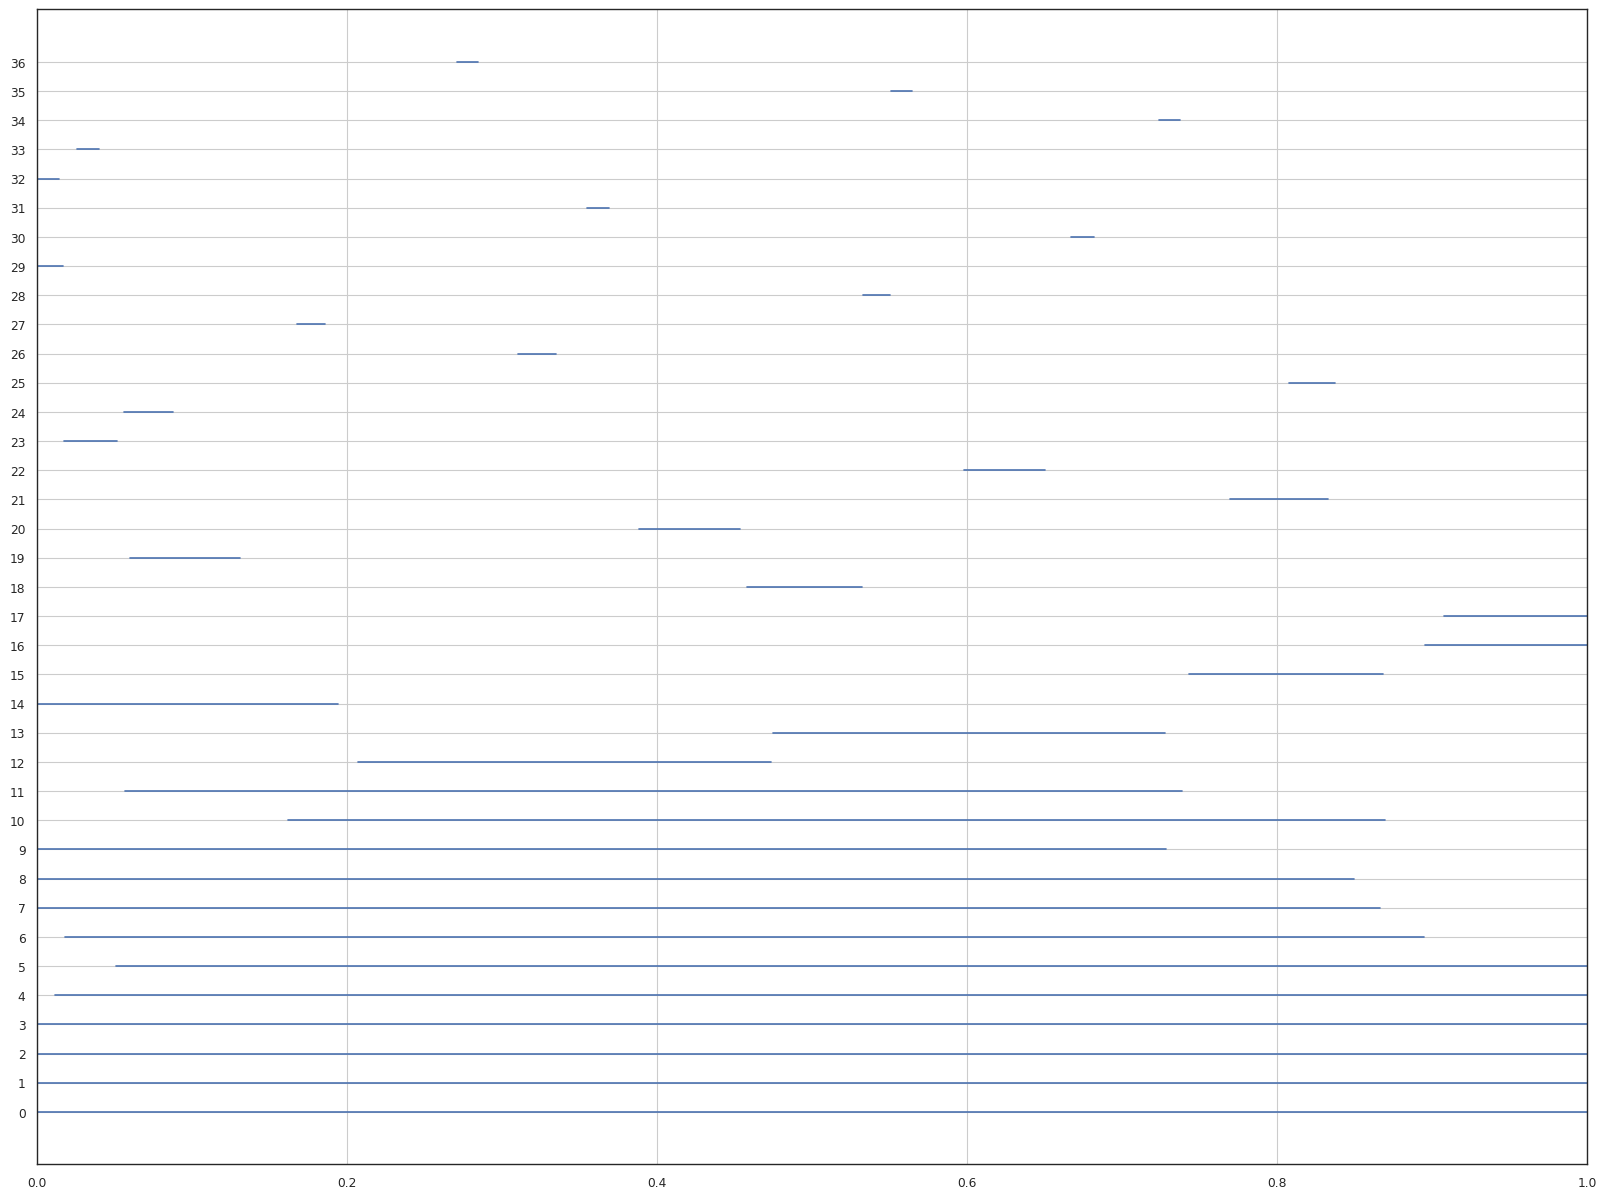

In [45]:
# Session B
df_tracking_new = df_trackingB.copy(deep=True)
total_idxs = df_id_start_stopB.max_idx.max()
for matched_id in potential_id_maps:
    to_match_id = potential_id_maps[matched_id]
    df_tracking_new[to_match_id] =  df_tracking_new[to_match_id].where(~df_tracking_new[to_match_id].isnull(), df_tracking_new[to_match_id])
    df_tracking_new = df_tracking_new.drop(matched_id, axis=1)
print("New tracking id for session A,",df_tracking_new.shape)
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop = df_id_start_stop[df_id_start_stop.total_idxs>MIN_ID_FRAMES].reset_index(drop=True)
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.sort_values(by='total_idxs',ascending=False).reset_index(drop=True).iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid()   

## Get embedding and gaze information for all frames for both sessions

In [70]:
# writing a generic loop to get embedding info from all courses in frame file data
emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info'
os.makedirs(emb_analysis_session_data,exist_ok=True)

for course_idx, course in enumerate(frame_file_data):
    for session_idx, session_id in enumerate(frame_file_data[course]):
        session_emb_cache_file = f"{emb_analysis_session_data}/{session_id}.pb"
        try:
            if not os.path.exists(session_emb_cache_file):
                session_dir = frame_file_data[course][session_id]['dir_location']
                frame_ids = frame_file_data[course][session_id]['frame_ids']
                session_emb_info = {}
                for frame_id in frame_ids:
                    frame_number, frame_data = pickle.load(open(f'{session_dir}/{frame_id}.pb','rb'))
                    frame_emb_info = {int(person_info['track_id']):{
                        'rvec': person_info['rvec'] if 'rvec' in person_info else None,
                        'gaze_2d':person_info['gaze_2d'] if 'gaze_2d' in person_info else None,
                        'face_embedding': person_info['face_embedding'] if 'face_embedding' in person_info else None,
                    } for person_info in frame_data}
                    session_emb_info[frame_id] = frame_emb_info
                pickle.dump(session_emb_info, open(session_emb_cache_file,'wb'))
                print(f"Got emb info for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
            else:
                ...
                print(f"FILE EXISTS: emb info for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
        except:
            print(f"ERROR: Unable to get session emb for: {course_idx}-{course}, session:{session_idx}-{session_id}")
            unfinished_sessions.append((course, session_id))
            print(traceback.format_exc())
    

Got emb info for session: 0-05410A, session:0-classinsight-cmu_05410A_ghc_4301_201902181500-front
Got emb info for session: 0-05410A, session:1-classinsight-cmu_05410A_ghc_4301_201902251500-front
Got emb info for session: 0-05410A, session:2-classinsight-cmu_05410A_ghc_4301_201904081500-front
Got emb info for session: 0-05410A, session:3-classinsight-cmu_05410A_ghc_4301_201904151500-front
Got emb info for session: 0-05410A, session:4-classinsight-cmu_05410A_ghc_4301_201904221500-front
Got emb info for session: 1-21127J, session:0-classinsight-cmu_21127J_ghc_4102_201903190930-front
Got emb info for session: 1-21127J, session:1-classinsight-cmu_21127J_ghc_4102_201903260930-front
Got emb info for session: 1-21127J, session:2-classinsight-cmu_21127J_ghc_4102_201904160930-front
Got emb info for session: 1-21127J, session:3-classinsight-cmu_21127J_ghc_4102_201904230930-front
Got emb info for session: 1-21127J, session:4-classinsight-cmu_21127J_ghc_4102_201904300930-front
Got emb info for ses

In [4]:
sessionA_emb_info = pickle.load(open(f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info/{sessionA}-front.pb','rb'))
sessionB_emb_info = pickle.load(open(f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info/{sessionB}-front.pb','rb'))

In [7]:
sessionA_id_map = pickle.load(open(f"{postprocessed_id_map_data_dir}/{sessionA}-front.pb","rb"))
sessionB_id_map = pickle.load(open(f"{postprocessed_id_map_data_dir}/{sessionB}-front.pb","rb"))


In [14]:
# sessionA_id_map

In [10]:
len(sessionB_emb_info.keys())

23913

In [21]:
sessionA_emb_info[3102].keys()

dict_keys([2, 3, 5, 12, 11, 6, 9, 1, 13, 0, 4, 8, 7, 10])

In [15]:
sessionA_emb_info = {
    xr:{
        sessionA_id_map[yr]:sessionA_emb_info[xr][yr] 
            for yr in sessionA_emb_info[xr] if not (sessionA_id_map[yr]==10000)} for xr in sessionA_emb_info}

In [16]:
sessionB_emb_info = {
    xr:{
        sessionB_id_map[yr]:sessionB_emb_info[xr][yr] 
            for yr in sessionB_emb_info[xr] if not (sessionB_id_map[yr]==10000)} for xr in sessionB_emb_info}

In [22]:
len(sessionA_emb_info.keys()), len(sessionB_emb_info.keys())

(11922, 23913)

In [97]:
# sessionA_emb_info[0][1]['face_embedding'].tolist()


In [23]:
# arrange info as per tracking id across both sessions
# pitch, roll, yaw= sessionA_emb_info[0][9]['rvec'][0]
gaze_infoA = {}
emb_infoA = {}
for frame_number in sessionA_emb_info:
    for trackId in sessionA_emb_info[frame_number]:
        if trackId not in gaze_infoA:
            gaze_infoA[trackId] = []
            emb_infoA[trackId]=[]
        # get  gaze info
        try:
            pitch, roll, yaw= sessionA_emb_info[frame_number][trackId]['rvec'][0]
            pitch, roll, yaw=np.rad2deg(pitch), np.rad2deg(roll), np.rad2deg(yaw)
            gaze_sx, gaze_sy, gaze_ex, gaze_ey = sessionA_emb_info[frame_number][trackId]['gaze_2d'][0].flatten()
            face_emb = sessionA_emb_info[frame_number][trackId]['face_embedding'].tolist()
            gaze_infoA[trackId].append([frame_number, pitch, roll, yaw, gaze_sx, gaze_sy, gaze_ex, gaze_ey])
            emb_infoA[trackId].append([frame_number]+face_emb)
        except:
            continue

for id in gaze_infoA:
    gaze_infoA[id] = pd.DataFrame(gaze_infoA[id], columns=['frame','pitch','roll','yaw','gaze_sx', 'gaze_sy', 'gaze_ex', 'gaze_ey']).set_index('frame')
    emb_infoA[id] =pd.DataFrame(emb_infoA[id], columns=['frame']+np.arange(512).tolist()).set_index('frame')

gaze_infoB = {}
emb_infoB = {}
for frame_number in sessionB_emb_info:
    for trackId in sessionB_emb_info[frame_number]:
        if trackId not in gaze_infoB:
            gaze_infoB[trackId] = []
            emb_infoB[trackId]=[]
        # get  gaze info
        try:
            pitch, roll, yaw= sessionB_emb_info[frame_number][trackId]['rvec'][0]    
            gaze_sx, gaze_sy, gaze_ex, gaze_ey = sessionB_emb_info[frame_number][trackId]['gaze_2d'][0].flatten()
            pitch, roll, yaw=np.rad2deg(pitch), np.rad2deg(roll), np.rad2deg(yaw)
            face_emb = sessionB_emb_info[frame_number][trackId]['face_embedding'].tolist()
            gaze_infoB[trackId].append([frame_number, pitch, roll, yaw, gaze_sx, gaze_sy, gaze_ex, gaze_ey])        
            emb_infoB[trackId].append([frame_number]+face_emb)
        except:
            continue


for id in gaze_infoB:
    gaze_infoB[id] = pd.DataFrame(gaze_infoB[id], columns=['frame','pitch','roll','yaw','gaze_sx', 'gaze_sy', 'gaze_ex', 'gaze_ey']).set_index('frame')
    emb_infoB[id] =pd.DataFrame(emb_infoB[id], columns=['frame']+np.arange(512).tolist()).set_index('frame')

In [26]:
gaze_infoA[0].head()

,pitch,roll,yaw,gaze_sx,gaze_sy,gaze_ex,gaze_ey
frame,,,,,,,
0,53.750755,-9.133966,30.301103,1645,147,1510,195
6,48.586583,-15.382676,36.168069,1638,145,1517,183
12,40.570633,-8.416896,18.881863,1631,159,1523,171
18,39.844151,-13.849055,22.652911,1634,163,1525,167
24,56.623160,-18.324299,40.789971,1649,145,1513,200


In [27]:
emb_infoA[0].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.003904,0.000272,-0.047923,0.030291,0.058400,0.002123,-0.039788,0.050282,-0.020974,0.073058,0.017956,0.022267,-0.051153,-0.067666,0.018393,-0.027658,-0.029551,0.090760,-0.043072,0.020721,-0.048786,0.048969,0.056317,-0.085657,-0.074638,-0.021815,0.036572,-0.024594,-0.065406,0.003081,-0.014670,0.034444,-0.009737,0.009257,0.009633,-0.013745,0.076833,-0.012675,-0.051579,0.036254,0.021265,0.044029,-0.008949,0.020025,0.024156,0.017477,-0.005296,0.024810,-0.129321,-0.016209,0.004134,-0.074141,-0.005462,0.003359,-0.080975,0.018338,-0.023866,0.017827,-0.008461,-0.044532,-0.041803,0.065721,-0.077133,-0.054805,-0.034903,-0.011242,0.016904,-0.038937,0.023694,-0.009113,0.055184,-0.016180,-0.051670,-0.056493,0.049804,-0.049225,-0.021318,0.009886,0.010085,-0.041114,0.048572,0.070336,0.043473,-0.085907,-0.041679,0.065975,-0.025014,0.027534,-0.059853,-0.011710,-0.038149,-0.014377,0.024542,-0.102409,-0.010896,0.003454,0.008810,0.010493,-0.071884,0.063461,-0.001895,0.064528,-0.003349,0.041461,-0.019577,0.019710,0.000214,-0.067673,-0.050933,-0.034179,0.027110,0.000458,-0.038791,0.003101,0.053016,0.075477,0.071670,0.069003,0.019962,0.042509,-0.034948,-0.022726,0.009379,0.003364,0.018697,-0.058427,-0.014469,0.001160,-0.055792,-0.080292,-0.010182,-0.098283,0.031709,-0.058622,0.013410,0.032221,-0.013028,-0.059414,0.014643,0.034619,-0.009651,0.035997,-0.074638,0.118395,0.023458,0.038761,-0.026667,0.032174,0.029851,0.038295,-0.047426,-0.017221,-0.081008,-0.018700,0.103730,-0.032874,-0.015257,0.043459,-0.037677,-0.027767,0.022180,0.039449,-0

In [28]:
np.nanmax([gaze_infoA[xr].roll.max() for xr in gaze_infoA])

179.9547797584779

In [29]:
angle_bins = np.arange(-180,360,60)
angle_bins

array([-180, -120,  -60,    0,   60,  120,  180,  240,  300])

In [30]:
for id in gaze_infoA:
    gaze_infoA[id]['roll_cat'] = [np.argmax(angle_bins>xr) for xr in gaze_infoA[id].roll]
    gaze_infoA[id]['pitch_cat'] = [np.argmax(angle_bins>xr) for xr in gaze_infoA[id].pitch]
    gaze_infoA[id]['yaw_cat'] = [np.argmax(angle_bins>xr) for xr in gaze_infoA[id].yaw]

for id in gaze_infoB:
    gaze_infoB[id]['roll_cat'] = [np.argmax(angle_bins>xr) for xr in gaze_infoB[id].roll]
    gaze_infoB[id]['pitch_cat'] = [np.argmax(angle_bins>xr) for xr in gaze_infoB[id].pitch]
    gaze_infoB[id]['yaw_cat'] = [np.argmax(angle_bins>xr) for xr in gaze_infoB[id].yaw]
    

In [31]:
# Data is ready, Now match id in one session to another session

In [32]:
df_temp = gaze_infoA[1].reset_index().groupby(['roll_cat', 'pitch_cat', 'yaw_cat'],as_index=False).agg({'frame':[lambda x: list(x), 'count']})
df_temp.columns = ['roll_cat', 'pitch_cat', 'yaw_cat','list','count']
df_temp = df_temp.sort_values(by='count', ascending=False)
df_temp

,roll_cat,pitch_cat,yaw_cat,list,count
45,4,4,3,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...",7832
40,4,3,4,"[408, 414, 420, 426, 432, 438, 462, 492, 498, ...",1140
39,4,3,3,"[444, 450, 456, 468, 474, 480, 486, 516, 522, ...",702
46,4,4,4,"[402, 1104, 2370, 3690, 3702, 3708, 5238, 5244...",550
27,3,4,3,"[312, 1572, 1578, 2172, 2532, 2538, 2874, 2880...",376
...,...,...,...,...,...
7,1,5,6,[29898],1
18,3,2,4,[16236],1
57,5,3,5,[31758],1
55,5,3,3,[69108],1


In [33]:
temp_gaze_framesA = df_temp.iloc[1]['list']
temp_roll, temp_pitch,temp_yaw= df_temp.iloc[1][['roll_cat','pitch_cat','yaw_cat']].values.tolist()
# temp_gaze_framesA
temp_roll, temp_pitch,temp_yaw

(4, 3, 4)

In [34]:
tmp_emb = emb_infoA[1][emb_infoA[1].index.isin(temp_gaze_framesA)]
tmp_emb

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
408,-0.011576,-0.004212,-0.065559,0.038454,0.068509,-0.006220,-0.048028,0.052591,0.002453,0.056931,0.020597,0.046521,-0.040752,-0.047696,0.025600,-0.033216,-0.001618,0.110838,-0.028088,0.014437,-0.035290,0.052691,0.074459,-0.075171,-0.064339,-0.026048,0.038476,-0.009190,-0.041318,0.001004,0.002555,0.020274,-0.015255,0.016169,0.024100,-0.018192,0.046101,-0.011260,-0.068115,0.073288,0.004559,0.024572,-0.005459,0.019439,0.016715,0.009256,0.010203,0.024493,-0.136728,-0.017889,0.001673,-0.048838,0.022774,-0.010909,-0.069443,0.018772,-0.039872,0.025842,-0.005662,-0.033409,-0.048905,0.052482,-0.076958,-0.041488,-0.034633,-0.008463,-0.010838,-0.027272,0.002563,-0.034148,0.047856,-0.032939,-0.049680,-0.063833,0.068926,-0.067247,-0.005801,0.010305,0.014169,-0.047705,0.023373,0.063472,0.030845,-0.084144,-0.057094,0.065325,-0.031167,0.045870,-0.070552,-0.019211,-0.033319,-0.005423,0.034735,-0.106133,-0.008607,0.002720,0.009107,0.018268,-0.053843,0.059965,-0.010503,0.083365,0.018247,0.028698,0.007181,0.017068,-0.024421,-0.064798,-0.032278,-0.030319,0.037281,0.009045,-0.043835,0.010277,0.071089,0.076797,0.072838,0.081879,-0.024359,0.027148,-0.028132,0.008671,0.005809,0.016367,0.012335,-0.058472,-0.029720,0.003710,-0.031252,-0.070825,-0.016201,-0.072218,0.071971,-0.074805,0.024746,0.032795,-0.026278,-0.073016,0.036481,0.028035,-0.007076,0.032814,-0.065113,0.106022,0.023988,0.026460,-0.058890,0.041359,0.050417,0.029521,-0.042534,-0.003627,-0.059012,0.007244,0.105001,-0.061044,0.004093,0.029070,-0.032294,-0.046179,0.014679,0.066162,-0

In [35]:
from sklearn.metrics import pairwise_distances

In [36]:
dist_mat = pairwise_distances(tmp_emb.values[:,:])
# sns.heatmap(dist_mat)

In [37]:
dist_thr = np.median(np.median(dist_mat, axis=1))
allowed_idx = np.median(dist_mat, axis=1)<dist_thr
dist_thr

0.11405047326278792

In [38]:
dist_mat = dist_mat[allowed_idx, :]
dist_mat = dist_mat[:,allowed_idx]
dist_mat.shape

(570, 570)

In [39]:
np.median(dist_mat, axis=1)<dist_thr
dist_mat.shape

(570, 570)

<Axes: >

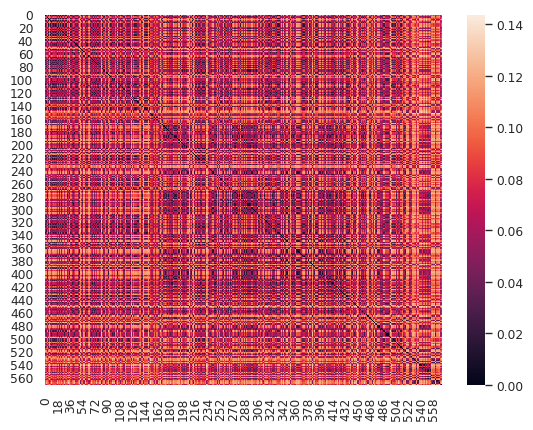

In [47]:
sns.heatmap(dist_mat)

In [46]:
gaze_infoA.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [41]:
tmp_emb.values

array([[-0.01157627, -0.00421249, -0.06555875, ..., -0.0532209 ,
        -0.02090906,  0.01244265],
       [-0.01778605,  0.00171495, -0.06778988, ..., -0.0557204 ,
        -0.02591241,  0.01537988],
       [-0.01563412,  0.00308807, -0.06665   , ..., -0.06052035,
        -0.02592683,  0.0122979 ],
       ...,
       [-0.00020627, -0.01994143, -0.06870805, ..., -0.04287609,
         0.00034458,  0.00851182],
       [-0.0220265 ,  0.00119857, -0.07428956, ..., -0.06695952,
        -0.0220407 ,  0.00538813],
       [-0.01552409, -0.0005713 , -0.06978278, ..., -0.06572442,
        -0.01711103,  0.00454739]])

In [42]:
dist_mat.shape

(570, 570)

In [48]:
# get embedding matrix for all gaze categories
@timer
def get_emb_matrices(df_id_gaze, df_id_emb, max_dist_threshold=0.5):
    df_gaze_cats = df_id_gaze.reset_index().groupby(['roll_cat', 'pitch_cat', 'yaw_cat'],as_index=False).agg({'frame':[lambda x: list(x), 'count']})
    df_gaze_cats.columns = ['roll_cat', 'pitch_cat', 'yaw_cat','list','count']
    df_gaze_cats = df_gaze_cats.sort_values(by='count', ascending=False)
    emb_matrices = {}
    for row_idx, row in df_gaze_cats.iterrows():
        temp_gaze_framesA = row['list']
        temp_roll, temp_pitch,temp_yaw= row['roll_cat'], row['pitch_cat'], row['yaw_cat']
    
        # get embedding matrix
        tmp_emb = df_id_emb[df_id_emb.index.isin(temp_gaze_framesA)]
    
        #filter outlier embeddings
        dist_mat = pairwise_distances(tmp_emb.values[:,:])
        dist_thr = min(np.median(np.median(dist_mat, axis=1)), max_dist_threshold)
        allowed_idx = np.median(dist_mat, axis=1)<dist_thr
    
        emb_matrix = tmp_emb.iloc[allowed_idx,:]
        emb_matrices[(temp_roll, temp_pitch,temp_yaw)] = emb_matrix
    return emb_matrices
    

emb_matsA = {}
for id in gaze_infoA.keys():
    sprint(id)
    emb_matsA[id] = get_emb_matrices(gaze_infoA[id],emb_infoA[id])
    # break

id : 0
Execution time: 1.833987 seconds
id : 1
Execution time: 3.255782 seconds
id : 2
Execution time: 0.009676 seconds
id : 3
Execution time: 0.004056 seconds
id : 4
Execution time: 0.003878 seconds
id : 5
Execution time: 1.461874 seconds
id : 6
Execution time: 0.005741 seconds
id : 7
Execution time: 1.390934 seconds
id : 8
Execution time: 1.955028 seconds
id : 9
Execution time: 1.364841 seconds
id : 10
Execution time: 0.005785 seconds
id : 11
Execution time: 0.476454 seconds
id : 12
Execution time: 0.005603 seconds
id : 13
Execution time: 1.822806 seconds
id : 14
Execution time: 0.005743 seconds
id : 15
Execution time: 0.204103 seconds
id : 16
Execution time: 0.005172 seconds
id : 17
Execution time: 0.007862 seconds
id : 18
Execution time: 0.004314 seconds
id : 19
Execution time: 0.004226 seconds
id : 20
Execution time: 0.034008 seconds
id : 21
Execution time: 0.004099 seconds
id : 22
Execution time: 0.003919 seconds
id : 23
Execution time: 0.015261 seconds
id : 24
Execution time: 0.

In [51]:

emb_matsB = {}
for id in gaze_infoB.keys():
    sprint(id)
    emb_matsB[id] = get_emb_matrices(gaze_infoB[id],emb_infoB[id])

id : 0
Execution time: 0.138236 seconds
id : 1
Execution time: 10.087710 seconds
id : 2
Execution time: 4.462747 seconds
id : 3
Execution time: 2.350332 seconds
id : 4
Execution time: 0.006032 seconds
id : 5
Execution time: 3.662657 seconds
id : 6
Execution time: 0.005736 seconds
id : 7
Execution time: 0.004039 seconds
id : 8
Execution time: 4.428210 seconds
id : 9
Execution time: 5.279302 seconds
id : 10
Execution time: 0.005898 seconds
id : 11
Execution time: 0.004003 seconds
id : 12
Execution time: 0.003930 seconds
id : 13
Execution time: 0.013822 seconds
id : 14
Execution time: 0.003992 seconds
id : 15
Execution time: 0.024411 seconds
id : 16
Execution time: 0.003942 seconds
id : 17
Execution time: 6.231358 seconds
id : 18
Execution time: 0.013357 seconds
id : 19
Execution time: 0.022985 seconds
id : 20
Execution time: 0.003995 seconds
id : 21
Execution time: 0.003918 seconds
id : 22
Execution time: 0.023435 seconds
id : 23
Execution time: 0.026425 seconds
id : 24
Execution time: 0

In [229]:
# matching score between different ids
temp_s1_mats=emb_matsA[0]
temp_s2_mats=emb_matsB[0]

In [231]:
common_keys = [xr for xr in temp_s1_mats.keys() if xr in temp_s2_mats.keys()]
common_keys

[(4, 4, 4),
 (4, 4, 3),
 (4, 3, 4),
 (3, 4, 4),
 (4, 3, 3),
 (3, 4, 3),
 (3, 4, 5),
 (5, 4, 3),
 (5, 3, 2),
 (5, 4, 2),
 (4, 4, 2),
 (5, 4, 4),
 (2, 3, 5)]

In [232]:
s1_emb_mat_key = temp_s1_mats[common_keys[0]]
s2_emb_mat_key = temp_s2_mats[common_keys[0]]
s1_emb_mat_key.shape, s2_emb_mat_key.shape

((2215, 512), (63, 512))

In [53]:
from scipy.spatial.distance import cdist
# dist_res = cdist(s1_emb_mat_key, s2_emb_mat_key)

In [234]:
dist_res.shape

(2215, 63)

In [246]:
# sns.heatmap(dist_res)

In [244]:
match_score = np.median(dist_res)

In [273]:
emb_matsA.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 23, 38, 50, 79, 82, 120, 163, 164, 184, 185, 219, 431, 433, 460, 482, 514, 519, 574, 627, 649, 672, 687, 690, 692, 697, 713, 758, 805, 821, 1001, 1006, 1092, 1136, 1141, 1162, 1220, 1287, 1310])

In [286]:
# get match scores between one single id from sessionA, and across all ids from sessionB
temp_idA_scores = dict()
temp_s1_mats=emb_matsA[697]
for idB in emb_matsB:
    temp_s2_mats = emb_matsB[idB]
    common_keys = [xr for xr in temp_s1_mats.keys() if xr in temp_s2_mats.keys()]
    temp_idA_scores[idB]={}
    for gaze_key in common_keys:
        s1_emb_mat_key = temp_s1_mats[gaze_key]
        s2_emb_mat_key = temp_s2_mats[gaze_key]
        dist_res = cdist(s1_emb_mat_key, s2_emb_mat_key)
        temp_idA_scores[idB][gaze_key] = np.median(dist_res)        
    


In [287]:
df_idA = pd.DataFrame(temp_idA_scores)

In [288]:
df_idA.min().sort_values()

1196    0.348587
901     0.522180
522     0.524195
866     0.562687
650     0.590487
49      0.637018
767     0.659601
1157    0.665690
4       0.676358
243     0.694063
586     0.694275
1       0.698936
1200    0.701874
1036    0.707789
6       0.721757
3       0.746151
206     0.801657
0       0.812260
9       0.837806
68      0.877153
32      0.977989
110     1.026286
1185    1.535858
5            NaN
7            NaN
8            NaN
13           NaN
25           NaN
30           NaN
34           NaN
35           NaN
94           NaN
112          NaN
121          NaN
178          NaN
277          NaN
289          NaN
302          NaN
312          NaN
323          NaN
439          NaN
690          NaN
729          NaN
745          NaN
790          NaN
807          NaN
937          NaN
984          NaN
1107         NaN
1165         NaN
1178         NaN
1189         NaN
1233         NaN
1246         NaN
dtype: float64

In [263]:
df_idA.min().sort_values()

243     0.145994
0       0.189567
206     0.198179
3       0.198194
1       0.199904
9       0.298187
767     0.305761
690     0.312205
6       0.315231
49      0.316022
650     0.329433
984     0.338652
1200    0.362976
68      0.411307
32      0.435395
13      0.436602
1157    0.699617
1036    0.734393
866     0.897853
901     0.922731
4       0.952842
1196    0.957821
522     1.000582
586     1.093636
5            NaN
7            NaN
8            NaN
25           NaN
30           NaN
34           NaN
35           NaN
94           NaN
110          NaN
112          NaN
121          NaN
178          NaN
277          NaN
289          NaN
302          NaN
312          NaN
323          NaN
439          NaN
729          NaN
745          NaN
790          NaN
807          NaN
937          NaN
1107         NaN
1165         NaN
1178         NaN
1185         NaN
1189         NaN
1233         NaN
1246         NaN
dtype: float64

In [289]:
# get final id-match matrix between both sessions

In [54]:
id_match_matrix = {}
for idA in emb_matsA:
    temp_s1_mats=emb_matsA[idA]
    id_match_matrix[idA]={}
    for idB in emb_matsB:
        temp_s2_mats = emb_matsB[idB]
        common_keys = [xr for xr in temp_s1_mats.keys() if xr in temp_s2_mats.keys()]
        # temp_idA_scores[idB]={}
        gaze_cat_scores= []
        for gaze_key in common_keys:
            s1_emb_mat_key = temp_s1_mats[gaze_key]
            s2_emb_mat_key = temp_s2_mats[gaze_key]
            dist_res = np.median(cdist(s1_emb_mat_key, s2_emb_mat_key))
            if dist_res >= 0:
                gaze_cat_scores.append(dist_res)
            # temp_idA_scores[idB][gaze_key] = np.median(dist_res) 
        if len(gaze_cat_scores)>0:
            id_match_matrix[idA][idB] = np.nanmin(gaze_cat_scores)


/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [55]:
df_id_match = pd.DataFrame(id_match_matrix)

<Axes: >

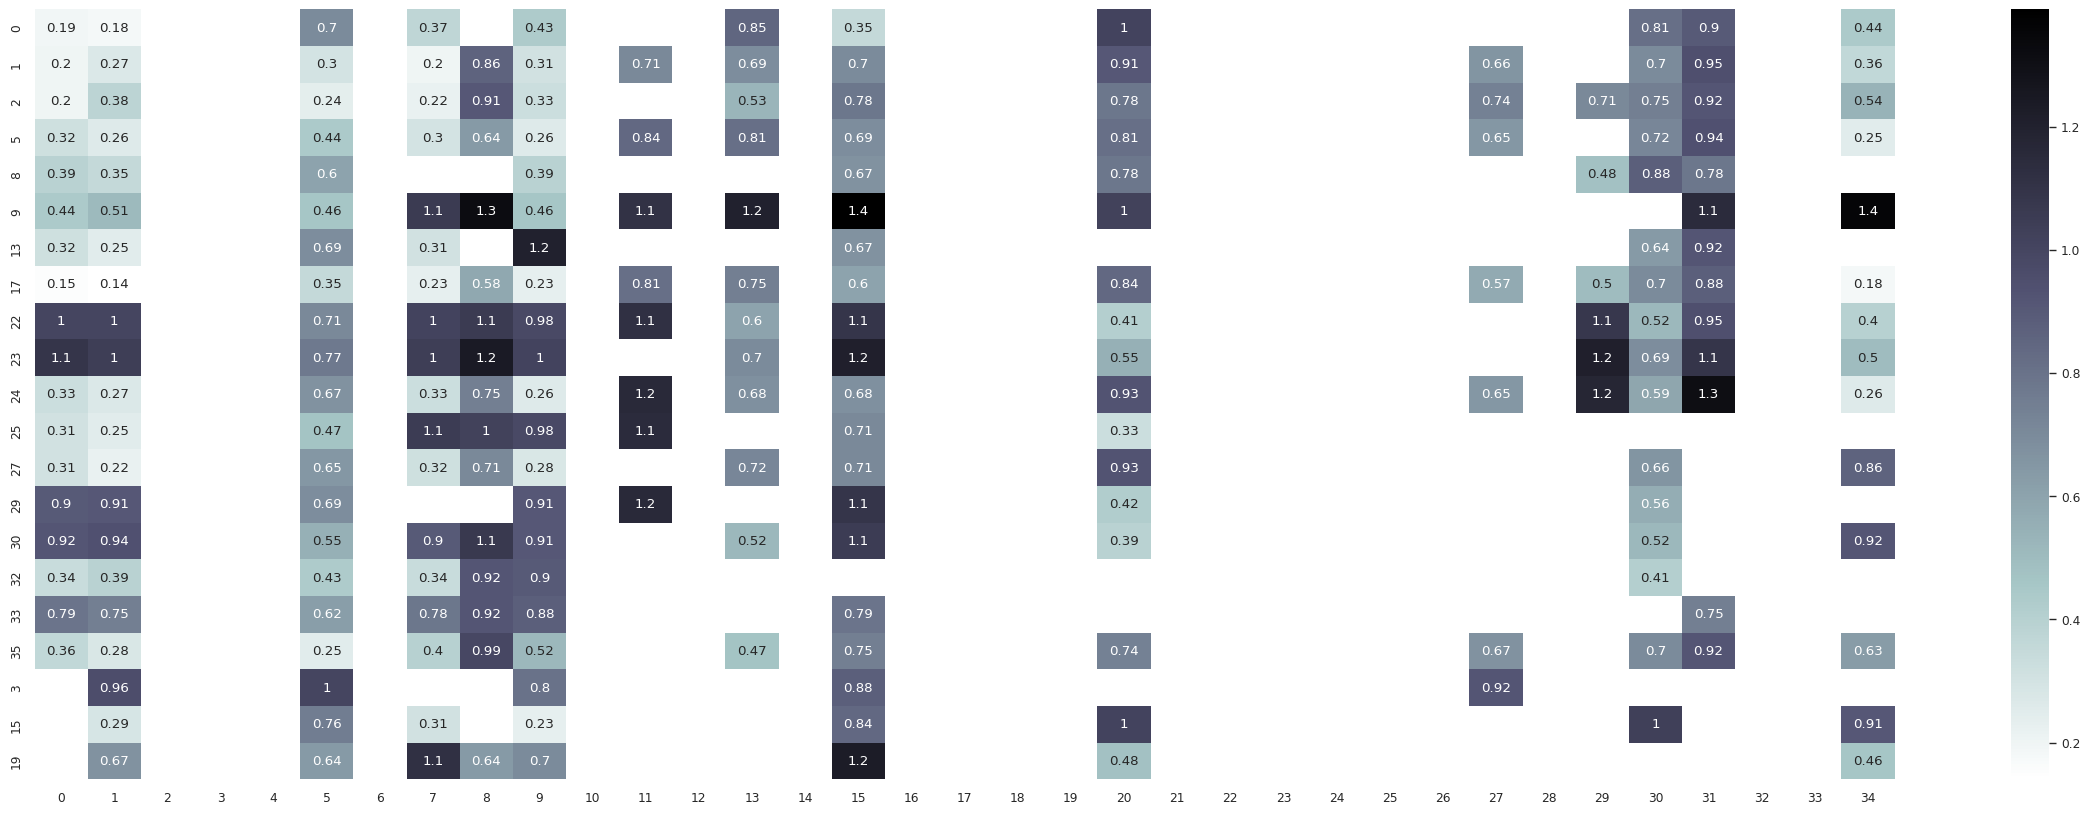

In [56]:
plt.figure(figsize=(30,10))
sns.heatmap(df_id_match.round(2), annot=True, cmap='bone_r')


In [57]:
df_id_match

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,0.189567,0.175864,NaN,NaN,NaN,0.697187,NaN,0.365490,NaN,0.432978,NaN,NaN,NaN,0.850572,NaN,0.352391,NaN,NaN,NaN,NaN,1.006868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.812260,0.903822,NaN,NaN,0.435338
1,0.199904,0.271530,NaN,NaN,NaN,0.298749,NaN,0.202618,0.855430,0.306604,NaN,0.713183,NaN,0.694547,NaN,0.696636,NaN,NaN,NaN,NaN,0.906324,NaN,NaN,NaN,NaN,NaN,NaN,0.660649,NaN,NaN,0.698936,0.946609,NaN,NaN,0.356625
2,0.198194,0.383326,NaN,NaN,NaN,0.239979,NaN,0.224543,0.912827,0.333390,NaN,NaN,NaN,0.527167,NaN,0.775958,NaN,NaN,NaN,NaN,0.778959,NaN,NaN,NaN,NaN,NaN,NaN,0.740736,NaN,0.707851,0.746151,0.924714,NaN,NaN,0.536229
5,0.315231,0.255361,NaN,NaN,NaN,0.438709,NaN,0.299567,0.640610,0.260120,NaN,0.844499,NaN,0.810763,NaN,0.691848,NaN,NaN,NaN,NaN,0.814267,NaN,NaN,NaN,NaN,NaN,NaN,0.645085,NaN,NaN,0.721757,0.941065,NaN,NaN,0.252767
8,0.391074,0.353143,NaN,NaN,NaN,0.601813,NaN,NaN,NaN,0.390429,NaN,NaN,NaN,NaN,NaN,0.671592,NaN,NaN,NaN,NaN,0.781420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.476967,0.877153,0.775382,NaN,NaN,NaN
9,0.436602,0.511737,NaN,NaN,NaN,0.459061,NaN,1.055834,1.320369,0.459468,NaN,1.114622,NaN,1.195115,NaN,1.393038,NaN,NaN,NaN,NaN,1.024527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.148251,NaN,NaN,1.357365
13,0.316022,0.252773,NaN,NaN,NaN,0.685441,NaN,0.311172,NaN,1.197617,NaN,NaN,NaN,NaN,NaN,0.674539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.637018,0.921445,NaN,NaN,NaN
17,0.145994,0.138806,NaN,NaN,NaN,0.348951,NaN,0.228687,0.579336,0.234121,NaN,0.809274,NaN,0.749971,NaN,0.600715,NaN,NaN,NaN,NaN,0.841092,NaN,NaN,NaN,NaN,NaN,NaN,0.573226,NaN,0.496543,0.697691,0.882126,NaN,NaN,0.175526
22,1.000582,1.004515,NaN,NaN,NaN,0.710105,NaN,1.014256,1.061177,0.981446,NaN,1.119690,NaN,0.604023,NaN,1.093195,NaN,NaN,NaN,NaN,0.410809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.084559,0.524195,0.950297,NaN,NaN,0.403745
23,1.093636,1.039807,NaN,NaN,NaN,0.773882,NaN,1.035953,1.242741,1.012070,NaN,NaN,NaN,0.703579,NaN,1.212580,NaN,NaN,NaN,NaN,0.548800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.213028,0.694275,1.093230,NaN,NaN,0.500895
